In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, LineString, Point
import xarray as xr
from glob import glob
import os
import cmocean as cm
import numpy as np

import pyresample

# -*- coding: utf-8 -*-
# Add the path to the Tatsu's swot library
import sys
sys.path.append('../src/')
import swot_utils
import plotting_scripts
import data_loaders
import download_swaths
import interp_utils

#turn off warnings
import warnings
warnings.filterwarnings("ignore")


################################################################
# Helper scripts for overlaying DUACS
################################################################
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

import datetime
def avg(dates):
  ref_date = np.datetime64('1900-01-01T00:00:00')
  return ref_date + sum([date - ref_date for date in dates], np.timedelta64()) / len(dates)


# A notebook to try some methods for calculating the spectrum

# Try Scott's re-gridding

In [5]:
import scipy.stats as stats

## Below is some of Scott's gridding and binning code for reference

```python
        n (int, optional): Number of bins in the output grid (default: 128).
        L_x (float, optional): Longitudinal range of the output grid in meters (default: 960e3).
        L_y (float, optional): Latitudinal range of the output grid in meters (default: 960e3).

        
        
        if self.withheld_sats is not None:
            tracks_in, tracks_out = extract_tracked(self.worker_ds_ssh, self.start_date, self.start_date+timedelta(days=self.N_t+1), self.L_x, self.L_y, lon0, lat0, transformer_ll2xyz, self.coord_grids[idx,], self.filtered_sla, withhold_sats = self.withheld_sats)
        else:
            tracks_in = extract_tracked(self.worker_ds_ssh, self.start_date, self.start_date+timedelta(days=self.N_t+1), self.L_x, self.L_y, lon0, lat0, transformer_ll2xyz, self.coord_grids[idx,], self.filtered_sla, withhold_sats = self.withheld_sats)
        ssh_in = grid_ssh(tracks_in, self.n, self.N_t, self.L_x, self.L_y, self.start_date)

```

# Try setting up a test pipeline
I'm going to start by binning to a ENU grid centered on the mean lat-lon coordinate of the first swath in the series

In [40]:
# Specify the path to the subsetted data
data_path = f"../SWOT_L3/Unsmoothed_kuroshio"

# Here I'm just pulling the first 10 cycles from the 1-day repeat Cal/Val phase
cycles = [str(c_num).zfill(3) for c_num in range(474,484)]

# Define domain
# Rough Agulhas, [lon, lat]
kuroshio_sw_corner = [140,15]
kuroshio_ne_corner = [170,40]
kuroshio_lat_lims = [kuroshio_sw_corner[1],kuroshio_ne_corner[1]]


# Use sph_science_swath for the 21-day repeat
# path_to_sph_file="../../orbit_data/sph_science_swath.zip"
# Use sph_calval_swath for the 1-day repeat
path_to_sph_file="../../orbit_data/sph_calval_swath.zip"

# Get pass IDs for swaths that intersect your box
pass_IDs_list = download_swaths.find_swaths(kuroshio_sw_corner, kuroshio_ne_corner,
                                           path_to_sph_file=path_to_sph_file)


swaths = []
times = []
cycle_data_check_list = []

for cycle in cycles:
    print(cycle)
    cycle_data = data_loaders.load_cycle(data_path,fields=["time","ssha","sigma0"],
                                                cycle=cycle,pass_ids=pass_IDs_list,subset=True,lats=kuroshio_lat_lims
                                               )
    cycle_data_check_list.append(cycle_data)

    
    for swath in cycle_data:
        times.append(swath.time.mean().values)
        swaths.append(interp_utils.grid_everything(swath.ssha, 35., 157.,  n=256, L_x=512e3, L_y=512e3))

        # Better to close the original swath file to avoid memory issues
        swath.close()
    
ssha_output = xr.concat(swaths,dim="time").assign_coords(time=("time",times))

474
Loading SWOT_L3_LR_SSH_Unsmoothed_474_019_20230329T132147_20230329T141138_v1.0.2_kuroshio.nc
Whoops, can't open dataset
An error occurred: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
475
Loading SWOT_L3_LR_SSH_Unsmoothed_475_004_20230330T002601_20230330T011706_v1.0.2_kuroshio.nc
476
Loading SWOT_L3_LR_SSH_Unsmoothed_476_019_20230331T130302_20230331T135253_v1.0.2_kuroshio.nc
477
478
Loading SWOT_L3_LR_SSH_Unsmoothed_478_004_20230401T235753_20230402T004859_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_019_20230402T124418_20230402T133408_v1.0.2_kuroshio.nc
479
Loading SWOT_L3_LR_SSH_Unsmoothed_479_004_20230402T234831_20230403T001052_v1.0.2_kuroshio.nc
Loading S

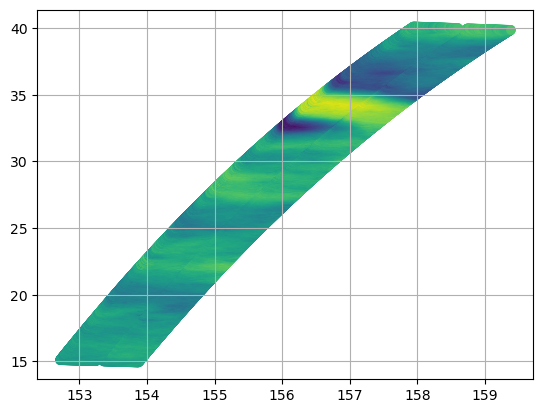

In [41]:
data = cycle_data_check_list[2][0].ssha

plt.scatter(data.longitude[::5,::5], data.latitude[::5,::5], c=data[::5,::5])
plt.grid()

plt.show()
plt.close()

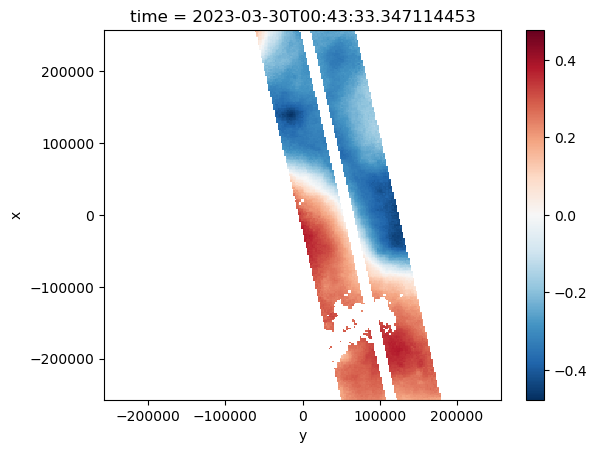

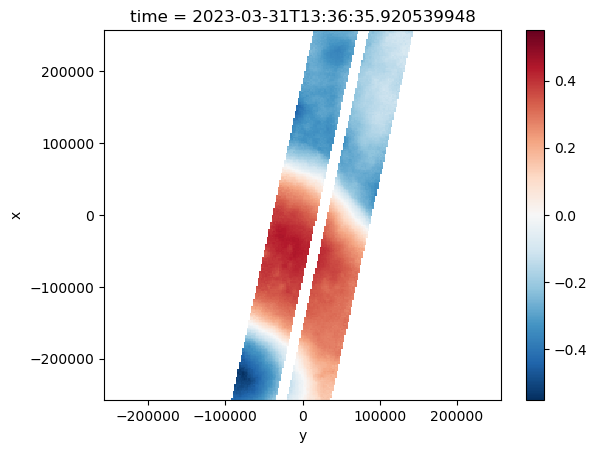

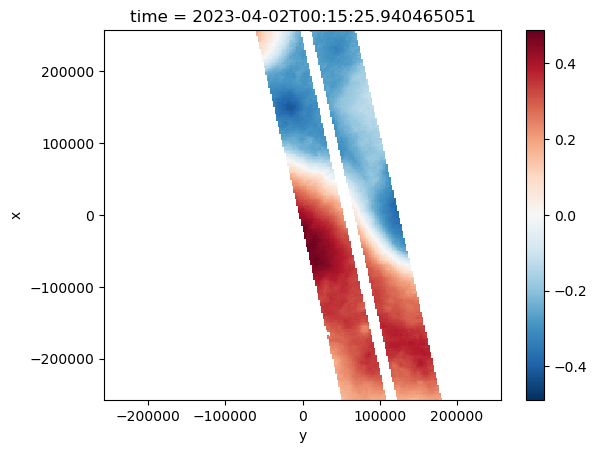

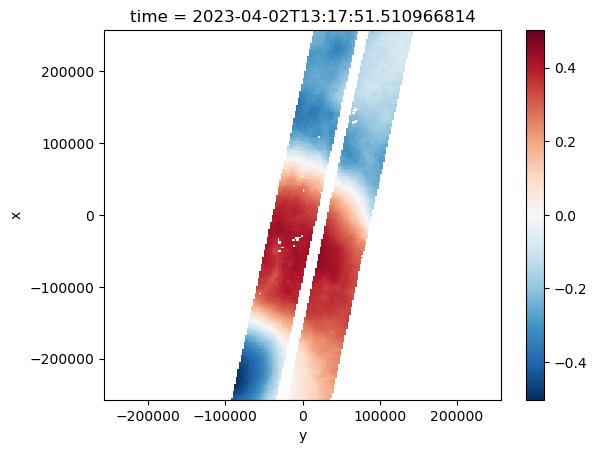

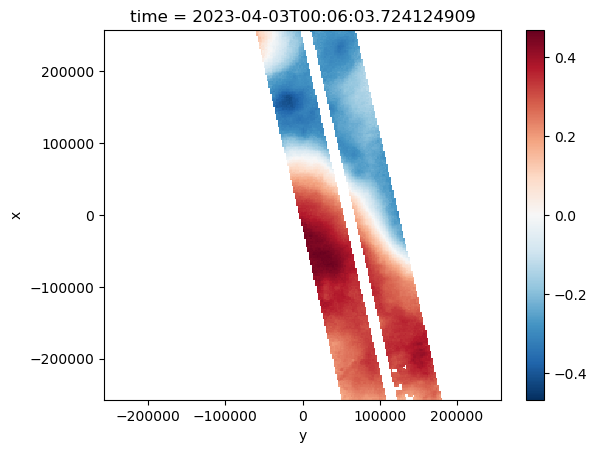

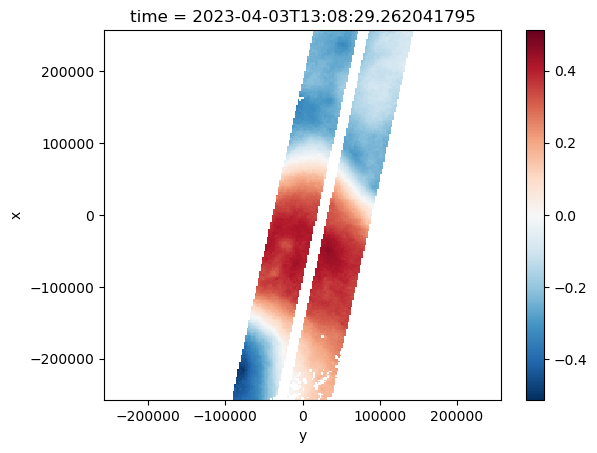

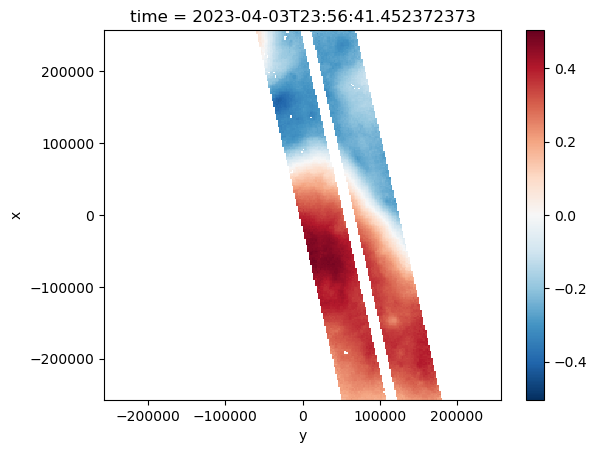

In [42]:
for t in range(len(ssha_output.time)):
    ssha_output.isel(time=t).plot()
    plt.show()
    plt.close()

# Make a movie!

GIF saved as 'interpolated_SWOT.gif'


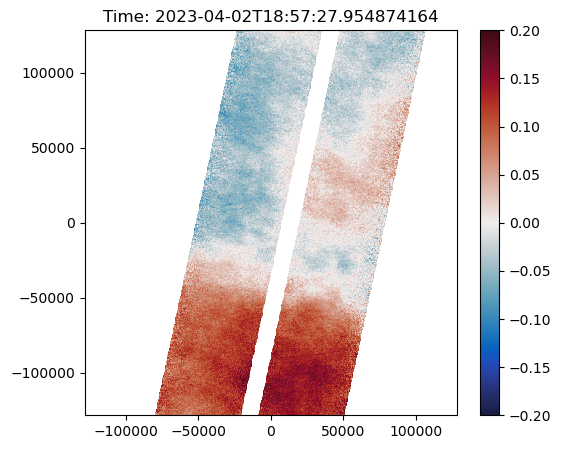

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import numpy as np

# Plot and save as GIF
# Plot and save as GIF
def create_gif_from_xarray(dataarray, gif_name="output.gif", fps=5, vmin=None, vmax=None):
    """
    Create a .gif from a time sequence of 2D xarray DataArray.

    Parameters
    ----------
    dataarray : xarray.DataArray
        The 2D+time data to be animated (must have dimensions "time", "x", "y").
    gif_name : str, optional
        Name of the output .gif file (default is "output.gif").
    fps : int, optional
        Frames per second for the GIF (default is 5).
    vmin, vmax : float, optional
        Minimum and maximum values for consistent colormap scaling across frames.
    """
    # Ensure the data has the required dimensions
    if not all(dim in dataarray.dims for dim in ["time", "x", "y"]):
        raise ValueError("The DataArray must have dimensions ('time', 'x', 'y').")

    # Get the colormap limits if not provided
    if vmin is None:
        vmin = dataarray.min().item()
    if vmax is None:
        vmax = dataarray.max().item()

    # Create the figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the first timestep to get the colorbar
    im = ax.pcolormesh(
        dataarray.x.values,
        dataarray.y.values,
        dataarray.isel(time=0).values,
        shading="auto",
        cmap=cm.cm.balance,
        vmin=vmin,
        vmax=vmax,
    )
    fig.colorbar(im, ax=ax, orientation="vertical", label=dataarray.name)
    
    # Define the update function for each frame
    def update(frame):
        ax.clear()  # Clear the previous frame
        ax.set_title(f"Time: {dataarray.time.values[frame]}")
        ax.pcolormesh(
            dataarray.x.values,
            dataarray.y.values,
            dataarray.isel(time=frame-1).values,
            shading="auto",
            cmap=cm.cm.balance,
            vmin=vmin,
            vmax=vmax,
            alpha=0.6
        )
        im = ax.pcolormesh(
            dataarray.x.values,
            dataarray.y.values,
            dataarray.isel(time=frame).values,
            shading="auto",
            cmap=cm.cm.balance,
            vmin=vmin,
            vmax=vmax,
        )
        return im

    # Create an animation writer
    writer = PillowWriter(fps=fps)
    writer.setup(fig, gif_name)

    # Generate the GIF frame by frame, starting from the second timestep
    for frame in range(1, len(dataarray.time)):
        update(frame)
        writer.grab_frame()

    # Finalize the writer and save the GIF
    writer.finish()

    print(f"GIF saved as '{gif_name}'")

# Example usage
create_gif_from_xarray(ssha_output[:], gif_name="interpolated_SWOT.gif", fps=2, vmin=-0.2,vmax=0.2)